### Take time series, associated RV measurement uncertainties, and planet orbital parameters and calculate the generalized (aka expected) Fisher Information Matrix (FIM)

Let's start with the most trivial case of circular orbit and white noise

In [168]:
import numpy as np 
import scipy
print(np.__version__)
print(scipy.__version__)

import pandas as pd
import exoplanet
import astropy 
import pymc3
import pymc3_ext
import celerite2
from numpy.linalg import inv, det
from tqdm import tqdm
import timeit

import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random

1.22.3
1.7.3


In [169]:
print(np.finfo(float).eps) # machine epsilon for float
print(np.finfo(float).precision) 
print(np.finfo(np.double).precision) 
print(np.finfo(np.longdouble).precision) 

2.220446049250313e-16
15
15
18


In [170]:
def partial_mu(t, theta, wrt):
    """
    Unpack parameters and calculate all partial derivatives of the model w.r.t. those parameters
    
    Inputs: 
    - t: time series of length N observations; np.array [day]
    - theta: planet orbital parameters; eg. [K, P, T0]; np.array
    - wrt: parameter with respect to which the model's partial derivative is taken
    
    theta breakdown:
    - K: RV semi-amplitude [cm/s]
    - P: planet period [days]
    - T0: mean transit time [day]
    
    Output:
    - derivative vector of length N
    """

    # unpack parameters
    K, P, T0 = theta[0], theta[1], theta[2]
    
    # calculate partial derivative depending on 'wrt'
    normalized_t = t-T0
    arg = (2*np.pi/P) * normalized_t
    
    if wrt=='K':
        return -np.sin(arg)
    elif wrt=='P':
        return K * np.cos(arg) * arg/P
    elif wrt=='T0':
        return (2*np.pi*K/P) * np.cos(arg)
    
    print("parameter not recognized")
    
    return                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

def calculate_fim(t, sigma, theta):
    """
    Calculate the generalized Fisher Information Matrix according to I_m,n in 
    https://en.wikipedia.org/wiki/Fisher_information#Multivariate_normal_distribution
    
    Inputs: 
    - t: time series of length N observations; np.array [day]
    - sigma: RV measurement uncertainties associated with each observation; np.array of length N [cm/s]
    - theta: planet orbital parameters; eg. [K, P, T0]; np.array
    
    theta breakdown:
    - K: RV semi-amplitude [cm/s]
    - P: planet period [days]
    - T0: mean transit time [day]
    
    Output:
    - Fisher Information Matrix: len(theta)xlen(theta) matrix; np.array
    
    """

    #print("partial mu, partial K: ", partial_mu(t, theta, 'K'))
    #print("partial mu, partial P: ", partial_mu(t, theta, 'P'))
    #print("partial mu, partial T0: ", partial_mu(t, theta, 'T0'))
    factor2 = 1/sigma**2
    factor2[factor2 == np.inf] = 0 
    
    fim = np.zeros((len(theta),len(theta)))
    
    for i in range(len(theta)):
        for j in range(len(theta)):
            #param_i = theta[i]
            #param_j = theta[j]
            wrt_i = param_list[i]
            wrt_j = param_list[j]
            
            factor1 = partial_mu(t, theta, wrt_i)#.reshape((1,4)) # partial derivative of the model wrt row parameter, transposed
            #print(factor1)
            ###factor2 = 1/sigma**2 # inverse of covariance matrix (or just the RV variance if held constant)
            ###factor2[factor2 == np.inf] = 0 # turn infs into zeros (shouldn't it be nans?)
            #print(factor2)
            factor3 = partial_mu(t, theta, wrt_j)#.reshape((4,1)) # partial derivative of the model wrt column parameter
            #print(factor3)
            #print("shapes: ", factor1.shape, factor2.shape, factor3.shape)
            #print(np.dot(np.dot(factor1, factor2), factor3))
            
            fim[i][j] = np.dot(np.dot(factor1, factor2), factor3)
    
    return fim

def calculate_fim_faster(t, sigma, theta):
    """
    Calculate the generalized Fisher Information Matrix by calculating partial derivatives only once
    and then plugging them into the right places. 
    
    Inputs: 
    - t: time series of length N observations; np.array [day]
    - sigma: RV measurement uncertainties associated with each observation; np.array of length N [cm/s]
    - theta: planet orbital parameters; eg. [K, P, T0]; np.array
    
    theta breakdown:
    - K: RV semi-amplitude [cm/s]
    - P: planet period [days]
    - T0: mean transit time [day]
    
    Output:
    - Fisher Information Matrix: len(theta)xlen(theta) matrix; np.array
    
    """
    
    factor2 = 1/sigma**2
    factor2[factor2 == np.inf] = 0 
    
    partial_k = partial_mu(t, theta, 'K')
    partial_p = partial_mu(t, theta, 'P')
    partial_t = partial_mu(t, theta, 'T0')
    
    fim = np.zeros((len(theta),len(theta)))
    
    for i in range(len(theta)):
        wrt_i = param_list[i]
        if wrt_i=='K':
            factor1 = partial_k
        elif wrt_i=='P':
            factor1 = partial_p
        elif wrt_i=='T0':
            factor1 = partial_t
        
        for j in range(len(theta)):
            wrt_j = param_list[j]
            if wrt_j=='K':
                factor3 = partial_k
            elif wrt_j=='P':
                factor3 = partial_p
            elif wrt_j=='T0':
                factor3 = partial_t
                            
            fim[i][j] = np.dot(np.dot(factor1, factor2), factor3)
    
    return fim

def calculate_fim_array(t, sigma, theta):
    """
    Calculate the generalized Fisher Information Matrix using np.stack instead of nested for loop
    
    Inputs: 
    - t: time series of length N observations; np.array [day]
    - sigma: RV measurement uncertainties associated with each observation; np.array of length N [cm/s]
    - theta: planet orbital parameters; eg. [K, P, T0]; np.array
    
    theta breakdown:
    - K: RV semi-amplitude [cm/s]
    - P: planet period [days]
    - T0: mean transit time [day]
    
    Output:
    - Fisher Information Matrix: len(theta)xlen(theta) matrix; np.array
    
    """
    
    factor2 = 1/sigma**2
    factor2[factor2 == np.inf] = 0 
    
    partial_k = partial_mu(t, theta, 'K')
    partial_p = partial_mu(t, theta, 'P')
    partial_t = partial_mu(t, theta, 'T0')
    
    #print(np.dot(np.dot(partial_k, factor2), partial_k))
    #print(np.array([np.dot(np.dot(partial_k, factor2), partial_k), np.dot(np.dot(partial_k, factor2), partial_p), np.dot(np.dot(partial_k, factor2), partial_t)]))
    
    fim = np.stack([np.array([np.dot(np.dot(partial_k, factor2), partial_k), np.dot(np.dot(partial_k, factor2), partial_p), np.dot(np.dot(partial_k, factor2), partial_t)]),
                  np.array([np.dot(np.dot(partial_p, factor2), partial_k), np.dot(np.dot(partial_p, factor2), partial_p), np.dot(np.dot(partial_p, factor2), partial_t)]),
                  np.array([np.dot(np.dot(partial_t, factor2), partial_k), np.dot(np.dot(partial_t, factor2), partial_p), np.dot(np.dot(partial_t, factor2), partial_t)])])
    
    return fim


In [171]:
print(calculate_fim(test_t, test_sigma, test_theta))
print(calculate_fim_faster(test_t, test_sigma, test_theta))
print(calculate_fim_array(test_t, test_sigma, test_theta))

ValueError: setting an array element with a sequence.

In [169]:
print("nested for loop: ", timeit.timeit("calculate_fim(test_t, test_sigma, test_theta)", globals=globals(), number=100000))
print("nested for loop but only calculating once: ", timeit.timeit("calculate_fim2(test_t, test_sigma, test_theta)", globals=globals(), number=100000))
print("array, and only calculating once: ", timeit.timeit("calculate_fim_array(test_t, test_sigma, test_theta)", globals=globals(), number=100000))


/var/folders/h2/sp_lfvz5515bhg_y92psw7f80000gn/T/ipykernel_20656/3682990251.py:60: RuntimeWarning: divide by zero encountered in true_divide
  factor2 = 1/sigma**2


nested for loop:  16.865128457953688


/var/folders/h2/sp_lfvz5515bhg_y92psw7f80000gn/T/ipykernel_20656/49658345.py:88: RuntimeWarning: divide by zero encountered in true_divide
  factor2 = 1/sigma**2


nested for loop but only calculating once:  7.264676249993499


/var/folders/h2/sp_lfvz5515bhg_y92psw7f80000gn/T/ipykernel_20656/3682990251.py:121: RuntimeWarning: divide by zero encountered in true_divide
  factor2 = 1/sigma**2


array, and only calculating once:  7.556727958028205


Let's try some test observations and planetary orbital parameters.

In [5]:
param_list = ['K','P','T0']

test_t = np.array([2340, 2350, 2380, 2400]) # in Barycentric Julian Dates
#test_t = np.array([2340, 2350, 2360, 2380]) # in Barycentric Julian Dates
#test_t = np.linspace(2340, 2380, 41) # in Barycentric Julian Dates

test_T0 = 2360 # BJD
test_K = 500 # 5 m/s to cm/s
test_P = 10 # days
test_sigma = np.diag(np.ones(len(test_t))*30) # cm/s
print(test_t.shape, test_sigma.shape)


(4,) (4, 4)


In [7]:
test_theta = [test_K, test_P, test_T0]
calculate_fim(test_t, test_sigma, test_theta)

/var/folders/h2/sp_lfvz5515bhg_y92psw7f80000gn/T/ipykernel_47798/4164931805.py:60: RuntimeWarning: divide by zero encountered in true_divide
  factor2 = 1/sigma**2


array([[1.66639976e-33, 2.13741188e-15, 2.56489426e-16],
       [2.13741188e-15, 2.74155678e+03, 3.28986813e+02],
       [2.56489426e-16, 3.28986813e+02, 4.38649084e+02]])

In [6]:
calculate_fim(test_t, test_sigma, test_theta)[0][0]

/tmp/ipykernel_3002366/564434563.py:60: RuntimeWarning: divide by zero encountered in true_divide
  factor2 = 1/sigma**2


1.666399758513175e-33

In [7]:
det(calculate_fim(test_t, test_sigma, test_theta))

/tmp/ipykernel_3002366/564434563.py:60: RuntimeWarning: divide by zero encountered in true_divide
  factor2 = 1/sigma**2


-3.3652495654758422e-43

In [8]:
inv(calculate_fim(test_t, test_sigma, test_theta))

/tmp/ipykernel_3002366/564434563.py:60: RuntimeWarning: divide by zero encountered in true_divide
  factor2 = 1/sigma**2


array([[-3.25191052e+48, -2.53530120e+30,  1.60664679e+13],
       [-2.53530120e+30, -1.97660795e+12,  3.13149263e-04],
       [ 0.00000000e+00,  3.00623292e-04,  2.50519410e-03]])

### What happens to the expected uncertainty on K when you incrementally add observations? 

${{\sigma}_k}^2$ is the top-leftmost cell of the inverse of the FIM. The second diagonal term is ${{\sigma}_P}^2$, and so forth. The off-diagonals contain information about the uncertainties on our uncertainties for each parameter pair, but we will ignore those for now(/forever) because our priors on P and T0 from TESS will be quite strong. 

For reference:

K = 10 cm/s is gold standard. As an upper bound for K, try up to 100 m/s if I only have 10 observations. 

As for N_obs, there are standard stars with 1000s of observations. But 100 would be our upper limit for TESS stars. 

In [105]:
test_T0 = 2360 # BJD
test_K = 500 # 5 m/s to 500 cm/s; it worked for 10000 cm/s
test_P = 10 # days

test_theta = [test_K, test_P, test_T0]

test_t = np.linspace(2340, 2440, 101)
buffer = 2 # anything less and either sigma_k blows up, or I get det(fim)=0
sigma_ks = []
sigma_ks_stable = []
sigma_ks_squared = []
for i in tqdm(range(len(test_t)-(buffer-1))):
    # create time series and appropriately sized covariance matrix
    test_t_temp = test_t[:i+buffer]
    test_sigma = np.diag(np.ones(len(test_t_temp))*30) # cm/s
    
    # calculate FIM
    fim = calculate_fim(test_t_temp, test_sigma, test_theta)
    #print(test_t_temp)
    #print(fim)
    #print(det(fim))
    
    # invert the FIM
    try:
        inv_fim = inv(fim)
    except:
        print("determinant of singular matrix is: ", det(fim), " for ", fim)
    
    # calculate sigma_k
    sigma_k = np.sqrt(inv_fim)[0][0]
    sigma_k_squared = inv_fim[0][0]
    sigma_ks.append(sigma_k)
    sigma_ks_squared.append(sigma_k_squared)
    #print("sigma: ", sigma_k)
    
    # for det(FIM) <= 1e-15, use sqrt(1/FIM[0][0]) instead
    # why? bc of numerical instability: 
    # https://stackoverflow.com/questions/17136626/what-is-the-correct-stable-efficient-way-to-use-matrix-inversion-in-numpy
    sigma_k_stable = np.sqrt(1/fim[0][0])
    sigma_ks_stable.append(sigma_k_stable)
    
print(sigma_ks)
print(sigma_ks_stable)
#print(sigma_ks_squared)

  0%|                                                                                                                                               | 0/100 [00:00<?, ?it/s]/var/folders/h2/sp_lfvz5515bhg_y92psw7f80000gn/T/ipykernel_20656/4155203827.py:60: RuntimeWarning: divide by zero encountered in true_divide
  factor2 = 1/sigma**2
/var/folders/h2/sp_lfvz5515bhg_y92psw7f80000gn/T/ipykernel_20656/686824180.py:30: RuntimeWarning: invalid value encountered in sqrt
  sigma_k = np.sqrt(inv_fim)[0][0]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2547.44it/s]

[nan, 77.43352187572135, 21.097996079939183, 20.896806627714092, 19.743065550785943, 17.97178294634297, 15.843463857879867, 14.013067243073355, 13.78624529343358, 13.634147492972586, 13.026678393732407, 12.093884665972709, 11.253661535695933, 11.090923117356374, 11.048752278832056, 10.732819784413193, 10.182043476508868, 9.673206479472842, 9.553710258973297, 9.537212637459856, 9.3391018074, 8.965686242512454, 8.61529766981624, 8.523670304778754, 8.515799124256144, 8.377736790895744, 8.103366480659835, 7.84320436101496, 7.770339640375219, 7.7660664179557095, 7.663141762150121, 7.450629235229334, 7.247599572200858, 7.18796511042501, 7.185424772406647, 7.105035232006432, 6.93418193243781, 6.77002547265564, 6.720094813968562, 6.718479537545977, 6.653516632632694, 6.5122885828108945, 6.37599569547235, 6.333416859126475, 6.3323351087600575, 6.278459928166208, 6.159184717273299, 6.043669513793351, 6.006811482669014, 6.006056560767363, 5.960457146182526, 5.857982550656341, 5.758450236692388, 5

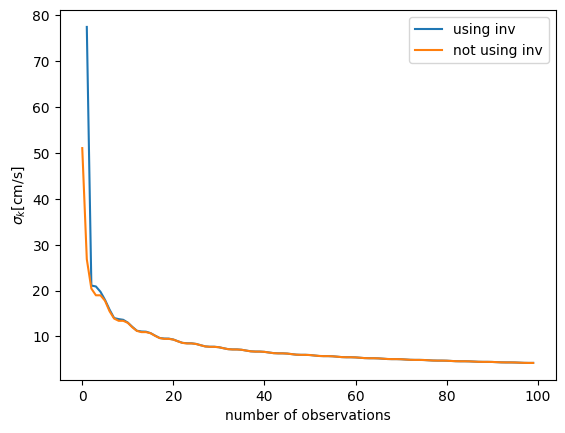

In [40]:
#plt.scatter(range(len(sigma_ks)), sigma_ks, s=5, label='using inv')
#plt.scatter(range(len(sigma_ks_stable)), sigma_ks_stable, s=5, label='not using inv')
plt.plot(range(len(sigma_ks)), sigma_ks, label='using inv')
plt.plot(range(len(sigma_ks_stable)), sigma_ks_stable, label='not using inv')
plt.xlabel('number of observations')
plt.ylabel(r"$\sigma_k$[cm/s]")
plt.legend()
plt.savefig('obs-vs-sigma_k.pdf', format='pdf')
plt.plot()
plt.show()

#### Side worry: sometimes, my FIMs are singular and can't be inverted. 

Upon inspection, it looks like the determinants are sometimes (rarely, but sometimes) zero, especially when there are very (too?) few observations. Upon further inspection, it looks like the matrix terms that go into calculating the determinants are often really small - like, smaller than machine epsilon small. What to do about it? Just ignore it? Uniformly add a scalar value to all matrix terms? 

I'm going to try a few things. 

First, let's just make a fiducial FIM and run det(fim). Then, let's run symbolic det on it. Then, let's manually compute det(fim). 

In [11]:
test_t = np.linspace(2340, 2400, 111) # 2340 to 2450, vs 2340 to 2400, for 111 obs
dets = []
sigma_ks_squared = []

# create time series and appropriately sized covariance matrix
test_t_temp = test_t[:2]
print(test_t_temp)
test_sigma = np.diag(np.ones(len(test_t_temp))*30) # cm/s

# calculate FIM
fim = calculate_fim(test_t_temp, test_sigma, test_theta)

print(fim) 
print(det(fim))
print(inv(fim))

"""
for i in range(len(test_t)-3):
    # create time series and appropriately sized covariance matrix
    test_t_temp = test_t[:i+4]
    test_sigma = np.diag(np.ones(len(test_t_temp))*30) # cm/s
    
    # calculate FIM
    fim = calculate_fim(test_t_temp, test_sigma, test_theta)
    dfadfdsf
"""

[2340.         2340.54545455]
[[ 1.25476883e-04 -2.14936766e-01 -1.10481515e-01]
 [-2.14936766e-01  8.06826970e+02  4.08574857e+02]
 [-1.10481515e-01  4.08574857e+02  2.06940470e+02]]
0.0


/tmp/ipykernel_3002366/564434563.py:60: RuntimeWarning: divide by zero encountered in true_divide
  factor2 = 1/sigma**2


LinAlgError: Singular matrix

^This is how I first noitced this problem. det(fim) is 0, and so inv(fim) errors out. 

EDIT: Upon even further inspection, it looks like sometimes just changing the time bound (while holding n_obs constant) will change an FIM from invertible to degenerate. For example, going from 2340-2450, to 2340-2400 BJD for 111 observations makes the FIM singular. Similarly, changing the number of observations for the same time support can make or break the matrix. Holding t at 2340-2400, going from 61 to 60 observations corrects the degeneracy of the matrix. (see below)

What if I manually calculated the determinant?

In [ ]:
1.25476883e-04*(8.06826970e+02*2.06940470e+02 - 4.08574857e+02*4.08574857e+02)

In [ ]:
 -2.14936766e-01 * (-2.14936766e-01 *2.06940470e+02 - -1.10481515e-01*4.08574857e+02)

In [ ]:
-1.10481515e-01*(-2.14936766e-01*4.08574857e+02 - 8.06826970e+02*-1.10481515e-01)

In [12]:
0.00398246159073211 - -0.14204178199869455 + -0.14602425317019033

-9.58076365464855e-09

In [13]:
det(fim)

0.0

In [14]:
import sympy as sp
from sympy import *
from sympy.matrices import Matrix

In [15]:
M = sp.Matrix(fim)

In [16]:
M.det()

1.77635683940025e-15

Why do these three methods mismatch??

Scarier scenario: even for the well-behaved FIMs, do manual, linalg, and sympy all disagree as well? Only one way to find out.

In [17]:
from numpy.linalg import inv, det

test_t = np.linspace(2340, 2400, 61) # 2340 to 2450, vs 2340 to 2400, for 111 obs
dets = []
sigma_ks_squared = []

# create time series and appropriately sized covariance matrix
test_t_temp = test_t[:2]
print(test_t_temp)
test_sigma = np.diag(np.ones(len(test_t_temp))*30) # cm/s

# calculate FIM
fim = calculate_fim(test_t_temp, test_sigma, test_theta)

print(fim) 
print(det(fim))
print(inv(fim))

[2340. 2341.]
[[ 3.83879448e-04 -3.15382284e-01 -1.65990676e-01]
 [-3.15382284e-01  6.97756431e+02  3.55696830e+02]
 [-1.65990676e-01  3.55696830e+02  1.81437159e+02]]
-4.547091327363591e-15
[[-1.73099608e+16  4.00319967e+14 -8.00639934e+14]
 [ 4.00319967e+14 -9.25802651e+12  1.85160530e+13]
 [-8.00639934e+14  1.85160530e+13 -3.70321060e+13]]


/tmp/ipykernel_3002366/564434563.py:60: RuntimeWarning: divide by zero encountered in true_divide
  factor2 = 1/sigma**2


In [18]:
-3.15382284e-01*1.81437159e+02 - -1.65990676e-01*3.55696830e+02

1.820291654865919

In [19]:
-3.15382284e-01*1.81437159e+02

-57.22206560789116

In [20]:
-1.65990676e-01*3.55696830e+02

-59.04235726275708

In [21]:
3.83879448e-04*(6.97756431e+02*1.81437159e+02 - 3.55696830e+02*3.55696830e+02)

0.030215014142300333

In [22]:
-3.15382284e-01*(-3.15382284e-01*1.81437159e+02 - -1.65990676e-01*3.55696830e+02)

-0.5740877396577533

In [23]:
-1.65990676e-01*(-3.15382284e-01*3.55696830e+02 - 6.97756431e+02 * -1.65990676e-01)

-0.6043028345449212

In [24]:
0.030215014142300333 - -0.5740877396577533 + -0.6043028345449212

-8.074486756992627e-08

In [25]:
M = sp.Matrix(fim)
M.det()

-3.55271367880050e-15

Aaaand, wolfram says -8e-8 (https://www.wolframalpha.com/input?i2d=true&i=%7B%7B3.83879448e-04%2C-3.15382284e-01%2C-1.65990676e-01%7D%2C%7B-3.15382284e-01%2C6.97756431e%2B02%2C3.55696830e%2B02%7D%2C%7B-1.65990676e-01%2C3.55696830e%2B02%2C1.81437159e%2B02%7D%7D). So sympy and linalg agree-ish (at least they're same order of magnitude), but they heavily disagree with manual and wolfram, which agree with each other.

I don't like this at all...

In [26]:
import scipy
scipy.linalg.det(fim)

-4.547091327363593e-15

At least scipy and numpy agree (I needed a small win). 

#### Let's try bumping all elements up by a scalar factor to get everyone comfortably larger than machine epsilon.

inv(kA) = inv(A)/k, so it should be safe to do this...?

In [17]:
fim*1e4

array([[ 3.83879448e+00, -3.15382284e+03, -1.65990676e+03],
       [-3.15382284e+03,  6.97756431e+06,  3.55696830e+06],
       [-1.65990676e+03,  3.55696830e+06,  1.81437159e+06]])

In [61]:
from numpy.linalg import inv, det

det(fim*1e4)

-0.0002483318143584188

In [25]:
det(fim)*1e4

-4.5470913273635905e-11

Wew. That's not supposed to happen, right?

In [22]:
3.83879448e+00*(6.97756431e+06*1.81437159e+06 - 3.55696830e+06*3.55696830e+06)

30215014142.29632

In [23]:
-3.15382284e+03*(-3.15382284e+03*1.81437159e+06 - -1.65990676e+03*3.55696830e+06)

-574087739657.7544

In [24]:
-1.65990676e+03*(-3.15382284e+03*3.55696830e+06 - -1.65990676e+03*6.97756431e+06)

-604302834544.921

In [26]:
30215014142.29632 - -574087739657.7544 + -604302834544.921

-80744.87036132812

In [49]:
import sympy as sp

print(sp.Matrix(fim*1e4).det())
print(sp.Matrix(fim*1e4).det()/1e4)

0.0117187500000000
1.17187500000000e-6


In [63]:
print(det(fim*1e5))
print(det(fim)*1e5)

-12.317257992177334
-4.5470913273635904e-10


Once again, Wolfram Alpha corroborates my manual determinant calculation and is much different from the np.linalg.det result: https://www.wolframalpha.com/input?i2d=true&i=%7B%7B3.83879448e-04%2C-3.15382284e-01%2C-1.65990676e-01%7D%2C%7B-3.15382284e-01%2C6.97756431e%2B02%2C3.55696830e%2B02%7D%2C%7B-1.65990676e-01%2C3.55696830e%2B02%2C1.81437159e%2B02%7D%7D

Furthermore, the manual/Wolfram determinant for the FIM scaled up by 1e4 has a determinant that's exactly 1e12 times bigger (from log -8 to log 4). When I scale the FIM up by 1e5, its determinant is then 8e7. So, with every scale by an order of magnitude, my determinant scales by three orders of magnitude (probably because it's a 3x3 matrix). 

And this time, np.linalg.det and sympy.Matrix(fim).det() disagree. 



Here's something from the Internet that can help: https://github.com/numpy/numpy/issues/6890

In [59]:
det(fim/np.amax(fim, axis=0, keepdims=True))

-6.336521960140912e-17

...

I need to reorient myself. Here's a base case.

In [67]:
import sympy as sp

a = np.array([[1, 2], [3,4]])
print(det(a))
print(sp.Matrix(a).det())
print(det(a*1e2))
print(det(a)*1e4)

-2.0000000000000004
-2
-19999.99999999998
-20000.000000000004


In [27]:
fim

array([[ 3.83879448e-04, -3.15382284e-01, -1.65990676e-01],
       [-3.15382284e-01,  6.97756431e+02,  3.55696830e+02],
       [-1.65990676e-01,  3.55696830e+02,  1.81437159e+02]])

In [33]:
type(fim[0][0])

numpy.float64

In [29]:
inv(fim)

array([[-1.73099608e+16,  4.00319967e+14, -8.00639934e+14],
       [ 4.00319967e+14, -9.25802651e+12,  1.85160530e+13],
       [-8.00639934e+14,  1.85160530e+13, -3.70321060e+13]])

In [30]:
scipy.linalg.inv(fim)

array([[-1.73099608e+16,  4.00319967e+14, -8.00639934e+14],
       [ 4.00319967e+14, -9.25802651e+12,  1.85160530e+13],
       [-8.00639934e+14,  1.85160530e+13, -3.70321060e+13]])

#### Other manual determinant calculations and scratch work for which I put too much time copy-pasting, so sunk-cost fallacy is making me not delete them..."yet"

In [20]:
3.99935942e-34*( 6.57973627e+02 * 4.38649084e+02 - 2.19324542e+02 * 2.19324542e+02) 

9.619110263099567e-29

In [21]:
-5.12978852e-16 * (-5.12978852e-16 *  4.38649084e+02 - -1.70992951e-16 * 2.19324542e+02)

9.619110266435248e-29

In [22]:
-1.70992951e-16 * (-5.12978852e-16 * 2.19324542e+02 - -1.70992951e-16*6.57973627e+02) 

-6.674154045664273e-38

In [23]:
9.619110263099567e-29 - 9.619110266435248e-29 + -6.674154045664273e-38

-1.0009835178189898e-37

In [15]:
1.05275780e+04*9.86960440e+02 - 1.97392088e+03*1.97392088e+03

6493939.374514345

In [14]:
1.97392088e+03*1.97392088e+03

3896363.640499974

In [13]:
1.05275780e+04*9.86960440e+02

10390303.015014319

In [9]:
6.39897507e-33 * (1.05275780e+04*9.86960440e+02 - 1.97392088e+03*1.97392088e+03)

4.155455616360869e-26

In [10]:
-8.20766163e-15 * (-8.20766163e-15*9.86960440e+02 - 1.53893655e-15*(-1.97392088e+03))

4.155455648018569e-26

In [11]:
1.53893655e-15 * (-8.20766163e-15*-1.97392088e+03 - 1.05275780e+04*1.53893655e-15)

1.5428752258607994e-34

In [12]:
4.155455616360869e-26 - 4.155455648018569e-26 + 1.5428752258607994e-34

-1.6228947576755225e-34

### Phase 2: Correlated Noise

Let's now add complexity to the covariance matrix, Sigma. Instead of it being just white noise (1/sigma_RV^2), it is now a quasi-periodic GP kernel, with free parameters given by the S-index part of Table 1 in Langellier et al 2020: https://iopscience.iop.org/article/10.3847/1538-3881/abf1e0/meta#ajabf1e0t1

In [ ]:
### free parameters from Langellier et al 2020
# let's hold these constant for now, but maybe we should sample from the given uncertainties later?
Tau = 23.6 # active region lifetime; days
eta = 0.58 # smoothing parameter
Prot = 28.1 # solar rotation period; days
sigma_qp_s = 1.43e3 # correlated noise amplitude
sigma_wn_s = 0.178e-3 # white noise amplitude

def cov_matrix(t, params):
    """
    Build a covariance matrix, Sigma, that will be used in the calculation of the Fisher Information Matrix
    
    Inputs:
    - t: time series of length N observations; np.array [day]
    - Tau: active region lifetime [days]; free param taken from Langellier et al 2020
    - eta: smoothing parameter; free param taken from Langellier et al 2020
    - Prot: rotation period [days]; free param taken from Langellier et al 2020
    - sigma_qp_s: correlated noise amplitude; free param taken from Langellier et al 2020
    - sigma_wn_s: white noise amplitude; free param taken from Langellier et al 2020
    
    Outputs:
    - N by N matrix of covariance elements following Equations 1 & 2 of Langellier et al 2020
    
    """
    
    Tau, eta, Prot, sigma_qp_s, sigma_wn_s = params[0], params[1], params[2], params[3], params[4]
    
    # create N by N matrix, where N is length of observations time series
    k = np.zeros((len(t),len(t)))
    
    for i in range(len(t)):
        for j in range(len(t)):
            term1 = ((t[i]-t[j])**2)/(2*Tau**2)
            term2 = (1/(2*eta**2)) * (np.sin(np.pi * (t[i] - t[j])/Prot))**2
            arg = term1 - term2
            k[i][j] = np.exp(arg)
    
    K = sigma_qp_s**2 * k + sigma_wn_s**2 * np.diag(np.ones(len(t)))
    
    return K



### JAX

In [160]:
def model_jax(t, K, P, T0): 
    """
    Radial velocity model, given timestamps and planetary orbital parameters
    
    Inputs: 
    - t: time series of length N observations; np.array [day]
    - K: RV semi-amplitude [cm/s]
    - P: planet period [days]
    - T0: mean transit time [day]

    """
    
    #K, P, T0 = theta[0], theta[1], theta[2]
    #normalized_t = (t-T0) % P
    arg = (2*jnp.pi/P)*(t-T0)
    rv = -K * jnp.sin(arg)
    
    return rv

In [161]:
def calculate_fim_jax(t, sigma, theta):

    factor2 = 1/sigma**2
    factor2[factor2 == np.inf] = 0 
    
    jac = jax.jacfwd(model_jax, argnums=[1,2,3])
    partial_k = np.array(jac(test_t, float(test_K), float(test_P), float(test_T0)))[0]
    partial_p = np.array(jac(test_t, float(test_K), float(test_P), float(test_T0)))[1]
    partial_t = np.array(jac(test_t, float(test_K), float(test_P), float(test_T0)))[2]
    
    fim = np.zeros((len(theta),len(theta)))
    
    for i in range(len(theta)):
        wrt_i = param_list[i]
        if wrt_i=='K':
            factor1 = partial_k
        elif wrt_i=='P':
            factor1 = partial_p
        elif wrt_i=='T0':
            factor1 = partial_t
        
        for j in range(len(theta)):
            wrt_j = param_list[j]
            if wrt_j=='K':
                factor3 = partial_k
            elif wrt_j=='P':
                factor3 = partial_p
            elif wrt_j=='T0':
                factor3 = partial_t
                            
            fim[i][j] = np.dot(np.dot(factor1, factor2), factor3)
    
    return fim

In [179]:
@jax.jit
def dfms_jax_version(t, sigma, theta): # thanks, Dan! 
    def inner(model_params):
        return model_normalized(t, model_params[0], model_params[1], model_params[2])
    
    sigma += 1e-6 # add jitter
    factor = jnp.linalg.solve(sigma, jnp.identity(len(sigma))) # take inverse of covariance matrix
    #factor = jnp.linalg.inv(sigma)
    #factor = jnp.where(sigma > 0, sigma_inv, 0)  
    
    J = jax.jacobian(inner)(theta)
    
    return J.T @ factor @ J

In [163]:
args = test_t, test_sigma**2, jnp.array(test_theta, dtype=float)
dfms_jax_version(*args).block_until_ready()

ValueError: The arguments to solve must have shapes a=[..., m, m] and b=[..., m, k] or b=[..., m]; got a=(1000,) and b=(1000, 1000)

In [277]:
print(calculate_fim(test_t, test_sigma, test_theta))
print(calculate_fim2(test_t, test_sigma, test_theta))
print(calculate_fim_array(test_t, test_sigma, test_theta))
print(calculate_fim_jax(test_t, test_sigma, test_theta))

[[5.55555556e-02 1.20111981e+00 4.20892991e-15]
 [1.20111981e+00 9.88576431e+04 1.67783275e+04]
 [4.12566318e-15 1.67783275e+04 5.59277583e+03]]
[[5.55555556e-02 1.20111981e+00 4.20892991e-15]
 [1.20111981e+00 9.88576431e+04 1.67783275e+04]
 [4.12566318e-15 1.67783275e+04 5.59277583e+03]]
[[5.55555556e-02 1.20111981e+00 4.20892991e-15]
 [1.20111981e+00 9.88576431e+04 1.67783275e+04]
 [4.12566318e-15 1.67783275e+04 5.59277583e+03]]
[[ 5.55555578e-02  1.20111460e+00 -1.17548240e-06]
 [ 1.20111460e+00  9.88576464e+04  1.67783275e+04]
 [-1.17548240e-06  1.67783275e+04  5.59277596e+03]]


/var/folders/h2/sp_lfvz5515bhg_y92psw7f80000gn/T/ipykernel_20656/3422004031.py:60: RuntimeWarning: divide by zero encountered in true_divide
  factor2 = 1/sigma**2
/var/folders/h2/sp_lfvz5515bhg_y92psw7f80000gn/T/ipykernel_20656/49658345.py:88: RuntimeWarning: divide by zero encountered in true_divide
  factor2 = 1/sigma**2
/var/folders/h2/sp_lfvz5515bhg_y92psw7f80000gn/T/ipykernel_20656/3422004031.py:121: RuntimeWarning: divide by zero encountered in true_divide
  factor2 = 1/sigma**2
/var/folders/h2/sp_lfvz5515bhg_y92psw7f80000gn/T/ipykernel_20656/1974187515.py:3: RuntimeWarning: divide by zero encountered in true_divide
  factor2 = 1/sigma**2


In [246]:
print("nested for loop: ", timeit.timeit("calculate_fim(test_t, test_sigma, test_theta)", globals=globals(), number=1000))
print("nested for loop but only calculating once: ", timeit.timeit("calculate_fim2(test_t, test_sigma, test_theta)", globals=globals(), number=1000))
print("array, and only calculating once: ", timeit.timeit("calculate_fim_array(test_t, test_sigma, test_theta)", globals=globals(), number=1000))

print("nested for loop, but only calculating once and with JAX: ", timeit.timeit("calculate_fim_jax(test_t, test_sigma, test_theta)", globals=globals(), number=1000))
print("DFM's JAX use: ", timeit.timeit("dfms_jax_version(*args).block_until_ready()", globals=globals(), number=1000))


/var/folders/h2/sp_lfvz5515bhg_y92psw7f80000gn/T/ipykernel_20656/3422004031.py:60: RuntimeWarning: divide by zero encountered in true_divide
  factor2 = 1/sigma**2
/var/folders/h2/sp_lfvz5515bhg_y92psw7f80000gn/T/ipykernel_20656/49658345.py:88: RuntimeWarning: divide by zero encountered in true_divide
  factor2 = 1/sigma**2


nested for loop:  0.18660495901713148
nested for loop but only calculating once:  0.07509366702288389
array, and only calculating once:  0.07595166604733095


/var/folders/h2/sp_lfvz5515bhg_y92psw7f80000gn/T/ipykernel_20656/3422004031.py:121: RuntimeWarning: divide by zero encountered in true_divide
  factor2 = 1/sigma**2
/var/folders/h2/sp_lfvz5515bhg_y92psw7f80000gn/T/ipykernel_20656/1974187515.py:3: RuntimeWarning: divide by zero encountered in true_divide
  factor2 = 1/sigma**2


nested for loop, but only calculating once and with JAX:  8.609815125004388
DFM's JAX use:  0.44954545801738277


In [247]:
%timeit calculate_fim(test_t, test_sigma, test_theta)
%timeit calculate_fim2(test_t, test_sigma, test_theta)
%timeit dfms_jax_version(*args).block_until_ready()

/var/folders/h2/sp_lfvz5515bhg_y92psw7f80000gn/T/ipykernel_20656/3422004031.py:60: RuntimeWarning: divide by zero encountered in true_divide
  factor2 = 1/sigma**2


175 µs ± 2.66 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


/var/folders/h2/sp_lfvz5515bhg_y92psw7f80000gn/T/ipykernel_20656/49658345.py:88: RuntimeWarning: divide by zero encountered in true_divide
  factor2 = 1/sigma**2


75.7 µs ± 927 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
440 µs ± 16.4 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


Why is JAX still slower? Dan said that it's fine because everything is fast enough. The advantage of JAX is that I don't have to derive all partials by hand when I change the model.

In [11]:
### free parameters from Langellier et al 2020
# let's hold these constant for now, but maybe we should sample from the given uncertainties later?
Tau = 23.6 # active region lifetime; days
eta = 0.58 # smoothing parameter
Prot = 28.1 # solar rotation period; days
sigma_qp_s = 1.43e-3 # correlated noise amplitude
sigma_wn_s = 0.178e-3 # white noise amplitude

def cov_matrix(t, params):
    """
    Build a covariance matrix, Sigma, that will be used in the calculation of the Fisher Information Matrix
    
    Inputs:
    - t: time series of length N observations; np.array [day]
    - Tau: active region lifetime [days]; free param taken from Langellier et al 2020
    - eta: smoothing parameter; free param taken from Langellier et al 2020
    - Prot: rotation period [days]; free param taken from Langellier et al 2020
    - sigma_qp_s: correlated noise amplitude; free param taken from Langellier et al 2020
    - sigma_wn_s: white noise amplitude; free param taken from Langellier et al 2020
    
    Outputs:
    - N by N matrix of covariance elements following Equations 1 & 2 of Langellier et al 2020
    
    """
    
    Tau, eta, Prot, sigma_qp_s, sigma_wn_s = params[0], params[1], params[2], params[3], params[4]
    
    # create N by N matrix, where N is length of observations time series
    k = np.zeros((len(t),len(t)))
    
    for i in range(len(t)):
        for j in range(len(t)):
            term1 = ((t[i]-t[j])**2)/(2*Tau**2)
            term2 = (1/(2*eta**2)) * (np.sin(np.pi * (t[i] - t[j])/Prot))**2
            arg = -term1 - term2
            k[i][j] = np.exp(arg)
    K = sigma_qp_s**2 * k + sigma_wn_s**2 * np.diag(np.ones(len(t)))
    
    return K

params = [Tau, eta, Prot, sigma_qp_s, sigma_wn_s]
#cov_matrix(strat, params)

In [279]:
test_sigma_correlated = cov_matrix(test_t, params)
args = test_t, test_sigma_correlated, jnp.array(test_theta, dtype=float)
print(dfms_jax_version(*args).block_until_ready())
print(calculate_fim2(test_t, test_sigma_correlated, test_theta))
#print(calculate_fim_array(test_t, test_sigma_correlated, test_theta))
#print(calculate_fim_jax(test_t, test_sigma_correlated, test_theta))

[[ 1.6059224e+08  3.5288011e+10 -4.3776000e+04]
 [ 3.5288289e+10  2.8544356e+14  4.7224310e+13]
 [ 1.4298535e+04  4.7224348e+13  1.5741440e+13]]
[[-7.46580526e+20 -1.54305262e+24  6.54311424e+08]
 [-1.54305262e+24 -1.53188892e+27  2.73888085e+26]
 [ 6.10803710e+08  2.73888085e+26  9.12960283e+25]]


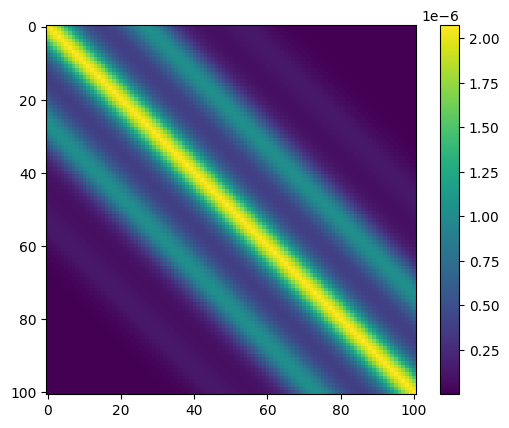

In [250]:
plt.imshow(test_sigma_correlated)
plt.colorbar()
plt.show()

In [219]:
%timeit calculate_fim(test_t, test_sigma_correlated, test_theta)
%timeit calculate_fim2(test_t, test_sigma_correlated, test_theta)
args = test_t, test_sigma_correlated, jnp.array(test_theta, dtype=float)
%timeit dfms_jax_version(*args).block_until_ready()

162 µs ± 410 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
65.2 µs ± 610 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
177 µs ± 237 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [ ]:
params

[23.6, 0.58, 28.1, 0.00143, 0.000178]

### Use case for DJ's NEID proposal

In [196]:
Prot = 10.8
Tau = 23.6 # active region lifetime; days
eta = 0.58 # smoothing parameter
sigma_wn_s = 200 # white noise amplitude, # cm/s
sigma_qp_s = 500 # correlated noise amplitude, cm/s
params = [Tau, eta, Prot, sigma_qp_s, sigma_wn_s]
test_K = 500 # cm/s
#sigma = 200 # cm/s

#start = 2360
test_P = 8.2
starts = np.linspace(2360-test_P, 2360, 200, endpoint=False)
start = 2358 #2355
dim = 100
cadences = np.linspace(0.30, 6.85, dim)
periods = np.array([test_P])
n_obs = 30 #40

sigma_k_test = []
sigma_k_solve_test = []
sigma_k_stable_test = []
fi_k_test = []

fi_k_jax_test = []
sigma_k_jax_test = []

#fi_jax = np.ones(len(periods)*len(cadences)).reshape((len(periods),len(cadences)))

for enum_c, c in enumerate(cadences):
    
    end = start + c * n_obs
    strat = np.linspace(start, end, n_obs, endpoint=False) + np.random.normal(0, 1./24)
    test_sigma_correlated = cov_matrix(strat, params)
    test_sigma_correlated += 1e-6
    test_theta = [test_K, test_P, test_T0]

    ### CALCULATE FIM
    #fim = calculate_fim_array(strat, test_sigma_correlated, test_theta)
    partial_k = partial_mu(strat, test_theta, 'K')
    partial_p = partial_mu(strat, test_theta, 'P')
    partial_t = partial_mu(strat, test_theta, 'T0')
    
    #print(np.dot(np.dot(partial_k, factor2), partial_k))
    #print(np.array([np.dot(np.dot(partial_k, factor2), partial_k), np.dot(np.dot(partial_k, factor2), partial_p), np.dot(np.dot(partial_k, factor2), partial_t)]))
    factor2 = np.linalg.solve(test_sigma_correlated, np.identity(len(test_sigma_correlated))) # invert to make factor2 for FIM
    fim = np.stack([np.array([np.dot(np.dot(partial_k, factor2), partial_k), np.dot(np.dot(partial_k, factor2), partial_p), np.dot(np.dot(partial_k, factor2), partial_t)]),
                  np.array([np.dot(np.dot(partial_p, factor2), partial_k), np.dot(np.dot(partial_p, factor2), partial_p), np.dot(np.dot(partial_p, factor2), partial_t)]),
                  np.array([np.dot(np.dot(partial_t, factor2), partial_k), np.dot(np.dot(partial_t, factor2), partial_p), np.dot(np.dot(partial_t, factor2), partial_t)])])
    
    inv_fim = inv(fim)
    sigma_k = np.sqrt(inv_fim)[0][0]
    sigma_k_stable = 1/np.sqrt(fim[0][0])
    sigma_k_solve = np.linalg.solve(fim, np.identity(len(fim)))[0][0] # invert to make factor2 for FIM
    
    #fim, sigma_k = strategy(start=start, n_obs=n_obs, cadence=c, theta=test_theta)#, sigma_val=sigma_wn_s)#, sigma_val=sigma)
    fi_k_test.append(fim[0][0])
    sigma_k_test.append(sigma_k)
    sigma_k_stable_test.append(sigma_k_stable)
    sigma_k_solve_test.append(sigma_k_solve)
    
    ### CALCULATE FIM BY JAX
    args = strat, test_sigma_correlated, jnp.array(test_theta, dtype=float)
    fim = dfms_jax_version(*args).block_until_ready()
    inv_fim = inv(fim)
    sigma_k = np.sqrt(inv_fim)[0][0]
    
    fi_k_jax_test.append(fim[0][0])
    sigma_k_jax_test.append(sigma_k)
    
    
#fi_k_test = np.array(fi_k_test)
#sigma_k_test = np.array(sigma_k_test)


/var/folders/h2/sp_lfvz5515bhg_y92psw7f80000gn/T/ipykernel_47798/117128919.py:51: RuntimeWarning: invalid value encountered in sqrt
  sigma_k = np.sqrt(inv_fim)[0][0]
/var/folders/h2/sp_lfvz5515bhg_y92psw7f80000gn/T/ipykernel_47798/117128919.py:65: RuntimeWarning: invalid value encountered in sqrt
  sigma_k = np.sqrt(inv_fim)[0][0]


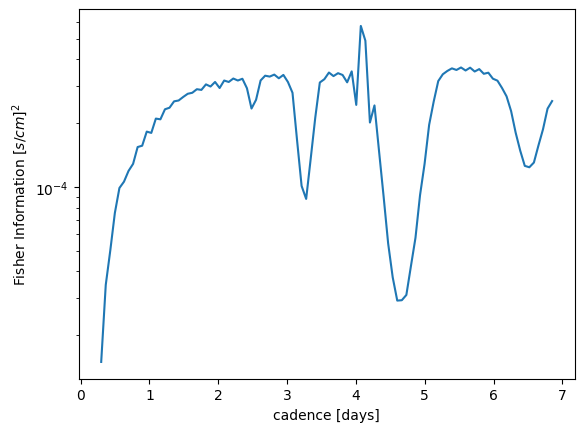

In [218]:
plt.plot(cadences, fi_k_jax_test)
plt.yscale('log')
#plt.xlim([1, 2])
#plt.ylim([3e-4, 1e-2])
plt.xlabel('cadence [days]')
plt.ylabel(r'Fisher Information $[s/cm]^2$')
#plt.ylabel(r'$\sigma_{K}$ [cm/s]')
#plt.savefig('sigma_k_for_dj.pdf', format='pdf')
#plt.savefig('fi_for_dj.pdf', format='pdf')
plt.show()

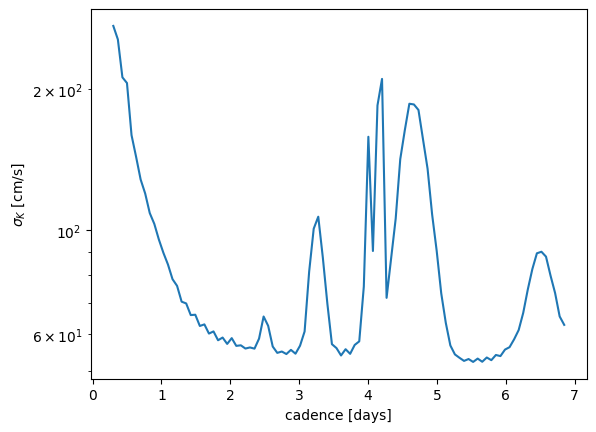

In [219]:
plt.plot(cadences, sigma_k_jax_test)
plt.yscale('log')
#plt.xlim([1, 2])
#plt.ylim([3e-4, 1e-2])
plt.xlabel('cadence [days]')
#plt.ylabel(r'Fisher Information $[s/cm]^2$')
plt.ylabel(r'$\sigma_{K}$ [cm/s]')
#plt.savefig('sigma_k_for_dj.pdf', format='pdf')
#plt.savefig('fi_for_dj_zoomed_in.pdf', format='pdf')
plt.show()

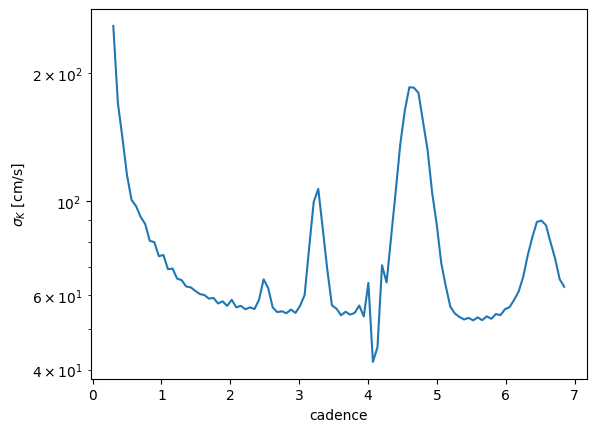

In [199]:
plt.plot(cadences, sigma_k_stable_test)
plt.yscale('log')
#plt.xlim([1, 2])
#plt.ylim([3e-4, 1e-2])
plt.xlabel('cadence')
#plt.ylabel(r'Fisher Information $[s/cm]^2$')
plt.ylabel(r'$\sigma_{K}$ [cm/s]')
#plt.savefig('sigma_k_for_dj.pdf', format='pdf')
#plt.savefig('fi_for_dj_zoomed_in.pdf', format='pdf')
plt.show()

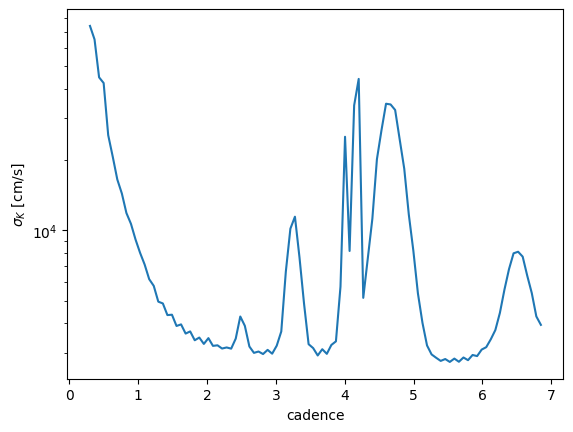

In [200]:
plt.plot(cadences, sigma_k_solve_test)
plt.yscale('log')
#plt.xlim([1, 2])
#plt.ylim([3e-4, 1e-2])
plt.xlabel('cadence')
#plt.ylabel(r'Fisher Information $[s/cm]^2$')
plt.ylabel(r'$\sigma_{K}$ [cm/s]')
#plt.savefig('sigma_k_for_dj.pdf', format='pdf')
#plt.savefig('fi_for_dj_zoomed_in.pdf', format='pdf')
plt.show()

#### Marginalize over start times

In [201]:
Prot = 10.8
Tau = 23.6 # active region lifetime; days
eta = 0.58 # smoothing parameter
sigma_wn_s = 200 # white noise amplitude, # cm/s
sigma_qp_s = 500 # correlated noise amplitude, cm/s
params = [Tau, eta, Prot, sigma_qp_s, sigma_wn_s]
test_K = 500 # cm/s
#sigma = 200 # cm/s

#start = 2360
test_P = 8.2
starts = np.linspace(2360-test_P, 2360, 200, endpoint=False)
start = 2300 #2355
dim = 100
cadences = np.linspace(0.30, 6.85, dim)
periods = np.array([test_P])
n_obs = 30 #40

sigma_k_test = []
sigma_k_solve_test = []
sigma_k_stable_test = []
fi_k_test = []

#fi_jax = np.ones(len(periods)*len(cadences)).reshape((len(periods),len(cadences)))

for enum_c, c in enumerate(cadences):
    fim_ii = 0
    sigma_k_ii = 0
    for start in starts:
        end = start + c * n_obs
        strat = np.linspace(start, end, n_obs, endpoint=False) + np.random.normal(0, 1./24)
        test_sigma_correlated = cov_matrix(strat, params)
        test_theta = [test_K, test_P, test_T0]

        ### CALCULATE FIM
        #fim = calculate_fim_array(strat, test_sigma_correlated, test_theta)
        partial_k = partial_mu(strat, test_theta, 'K')
        partial_p = partial_mu(strat, test_theta, 'P')
        partial_t = partial_mu(strat, test_theta, 'T0')

        #print(np.dot(np.dot(partial_k, factor2), partial_k))
        #print(np.array([np.dot(np.dot(partial_k, factor2), partial_k), np.dot(np.dot(partial_k, factor2), partial_p), np.dot(np.dot(partial_k, factor2), partial_t)]))
        factor2 = np.linalg.solve(test_sigma_correlated, np.identity(len(test_sigma_correlated))) # invert to make factor2 for FIM
        fim = np.stack([np.array([np.dot(np.dot(partial_k, factor2), partial_k), np.dot(np.dot(partial_k, factor2), partial_p), np.dot(np.dot(partial_k, factor2), partial_t)]),
                      np.array([np.dot(np.dot(partial_p, factor2), partial_k), np.dot(np.dot(partial_p, factor2), partial_p), np.dot(np.dot(partial_p, factor2), partial_t)]),
                      np.array([np.dot(np.dot(partial_t, factor2), partial_k), np.dot(np.dot(partial_t, factor2), partial_p), np.dot(np.dot(partial_t, factor2), partial_t)])])

        inv_fim = inv(fim)
        sigma_k = np.sqrt(inv_fim)[0][0]
        #sigma_k_stable = 1/np.sqrt(fim[0][0])
        #sigma_k_solve = np.linalg.solve(fim, np.identity(len(fim)))[0][0] # invert to make factor2 for FIM

        #fim, sigma_k = strategy(start=start, n_obs=n_obs, cadence=c, theta=test_theta)#, sigma_val=sigma_wn_s)#, sigma_val=sigma)
        
        fim_ii += fim[0][0]
        sigma_k_ii += sigma_k
        
    fim_ii = fim_ii/200.
    sigma_k_ii = sigma_k_ii/200.
    
    fi_k_test.append(fim_ii)
    sigma_k_test.append(sigma_k_ii)
    #sigma_k_stable_test.append(sigma_k_stable)
    #sigma_k_solve_test.append(sigma_k_solve)
        
#fi_k_test = np.array(fi_k_test)
#sigma_k_test = np.array(sigma_k_test)



/var/folders/h2/sp_lfvz5515bhg_y92psw7f80000gn/T/ipykernel_47798/3550849465.py:49: RuntimeWarning: invalid value encountered in sqrt
  sigma_k = np.sqrt(inv_fim)[0][0]


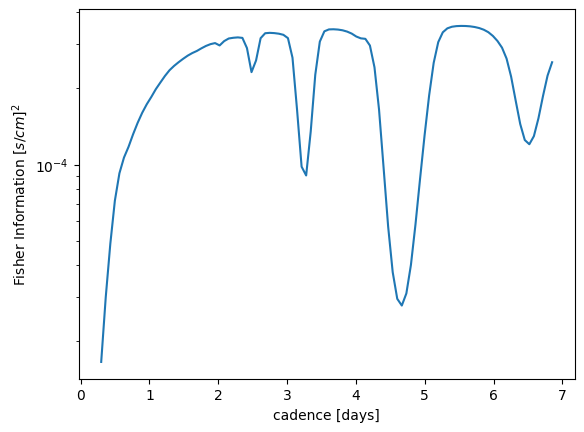

In [220]:
plt.plot(cadences, fi_k_test)
plt.yscale('log')
#plt.xlim([1, 2])
#plt.ylim([3e-4, 1e-2])
plt.xlabel('cadence [days]')
plt.ylabel(r'Fisher Information $[s/cm]^2$')
#plt.ylabel(r'$\sigma_{K}$ [cm/s]')
#plt.savefig('sigma_k_for_dj.pdf', format='pdf')
plt.savefig('fi_for_dj_marginalized.pdf', format='pdf')
plt.show()

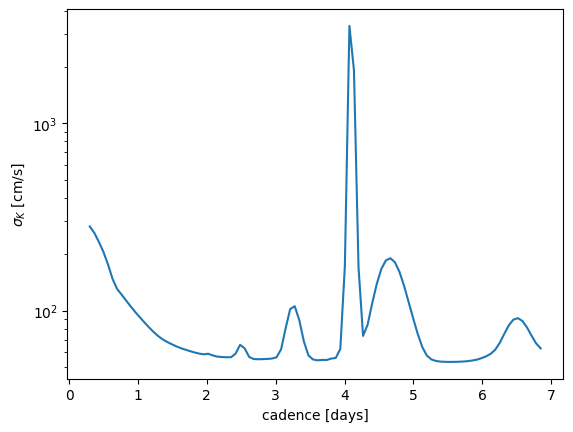

In [221]:
plt.plot(cadences, sigma_k_test)
plt.yscale('log')
#plt.xlim([1, 2])
#plt.ylim([3e-4, 1e-2])
plt.xlabel('cadence [days]')
#plt.ylabel(r'Fisher Information $[s/cm]^2$')
plt.ylabel(r'$\sigma_{K}$ [cm/s]')
plt.savefig('sigma_k_for_dj_marginalized.pdf', format='pdf')
#plt.savefig('fi_for_dj_zoomed_in.pdf', format='pdf')
plt.show()

#### White noise

In [42]:
Prot = 10.8
Tau = 23.6 # active region lifetime; days
eta = 0.58 # smoothing parameter
sigma_wn_s = 200 # white noise amplitude, # cm/s
sigma_qp_s = 500 # correlated noise amplitude, cm/s
params = [Tau, eta, Prot, sigma_qp_s, sigma_wn_s]
test_K = 500 # cm/s
#sigma = 200 # cm/s

#start = 2360
test_P = 8.2
starts = np.linspace(2360-test_P, 2360, 200, endpoint=False)
start = 2300 #2355
dim = 100
cadences = np.linspace(0.30, 6.85, dim)
periods = np.array([test_P])
n_obs = 30 #40

sigma_k_test = []
sigma_k_solve_test = []
sigma_k_stable_test = []
fi_k_test = []

#fi_jax = np.ones(len(periods)*len(cadences)).reshape((len(periods),len(cadences)))

for enum_c, c in enumerate(cadences):
    fim_ii = 0
    sigma_k_ii = 0
    for start in starts:
        end = start + c * n_obs
        strat = np.linspace(2300, end, n_obs, endpoint=False) + np.random.normal(0, 1./24)
        sigma_wn_s += 1e-6 # perturb sigma_val to guard against numerical instabilities
        sigma = np.diag(np.ones(len(strat))) * sigma_wn_s**2 # covariance matrix of scalar sigma_RV's
        
        test_theta = [test_K, test_P, test_T0]

        ### CALCULATE FIM
        #fim = calculate_fim_array(strat, test_sigma_correlated, test_theta)
        partial_k = partial_mu(strat, test_theta, 'K')
        partial_p = partial_mu(strat, test_theta, 'P')
        partial_t = partial_mu(strat, test_theta, 'T0')

        #print(np.dot(np.dot(partial_k, factor2), partial_k))
        #print(np.array([np.dot(np.dot(partial_k, factor2), partial_k), np.dot(np.dot(partial_k, factor2), partial_p), np.dot(np.dot(partial_k, factor2), partial_t)]))
        factor2 = np.linalg.solve(sigma, np.identity(len(sigma))) # invert to make factor2 for FIM
        fim = np.stack([np.array([np.dot(np.dot(partial_k, factor2), partial_k), np.dot(np.dot(partial_k, factor2), partial_p), np.dot(np.dot(partial_k, factor2), partial_t)]),
                      np.array([np.dot(np.dot(partial_p, factor2), partial_k), np.dot(np.dot(partial_p, factor2), partial_p), np.dot(np.dot(partial_p, factor2), partial_t)]),
                      np.array([np.dot(np.dot(partial_t, factor2), partial_k), np.dot(np.dot(partial_t, factor2), partial_p), np.dot(np.dot(partial_t, factor2), partial_t)])])

        inv_fim = inv(fim)
        sigma_k = np.sqrt(inv_fim)[0][0]
        #sigma_k_stable = 1/np.sqrt(fim[0][0])
        #sigma_k_solve = np.linalg.solve(fim, np.identity(len(fim)))[0][0] # invert to make factor2 for FIM

        #fim, sigma_k = strategy(start=start, n_obs=n_obs, cadence=c, theta=test_theta)#, sigma_val=sigma_wn_s)#, sigma_val=sigma)
        
        fim_ii += fim[0][0]
        sigma_k_ii += sigma_k
        
    fim_ii = fim_ii/200.
    sigma_k_ii = sigma_k_ii/200.
    
    fi_k_test.append(fim_ii)
    sigma_k_test.append(sigma_k_ii)
    #sigma_k_stable_test.append(sigma_k_stable)
    #sigma_k_solve_test.append(sigma_k_solve)
        
#fi_k_test = np.array(fi_k_test)
#sigma_k_test = np.array(sigma_k_test)




/var/folders/h2/sp_lfvz5515bhg_y92psw7f80000gn/T/ipykernel_47798/4288345134.py:51: RuntimeWarning: invalid value encountered in sqrt
  sigma_k = np.sqrt(inv_fim)[0][0]


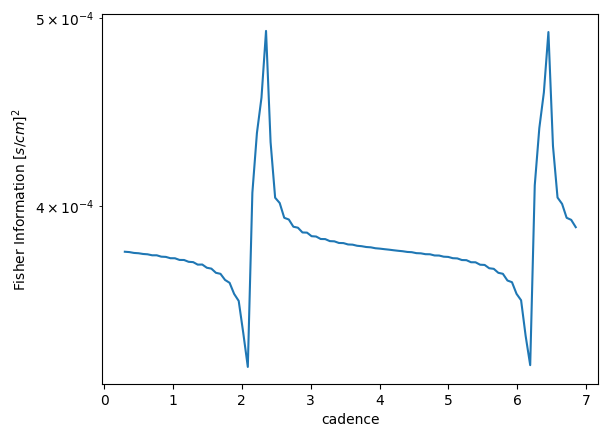

In [43]:
plt.plot(cadences, fi_k_test)
plt.yscale('log')
#plt.xlim([1, 2])
#plt.ylim([3e-4, 1e-2])
plt.xlabel('cadence')
plt.ylabel(r'Fisher Information $[s/cm]^2$')
#plt.ylabel(r'$\sigma_{K}$ [cm/s]')
#plt.savefig('sigma_k_for_dj.pdf', format='pdf')
#plt.savefig('fi_for_dj_marginalized.pdf', format='pdf')
plt.show()

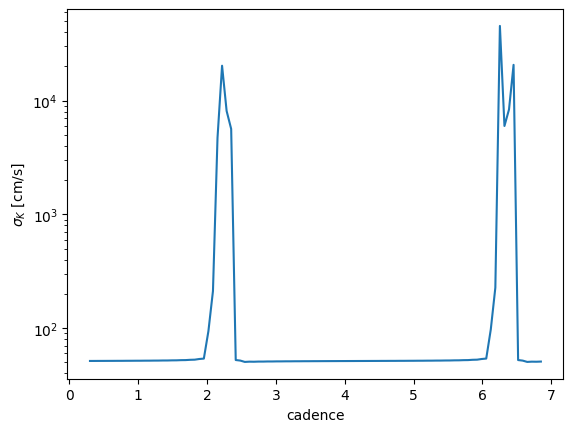

In [44]:
plt.plot(cadences, sigma_k_test)
plt.yscale('log')
#plt.xlim([1, 2])
#plt.ylim([3e-4, 1e-2])
plt.xlabel('cadence')
#plt.ylabel(r'Fisher Information $[s/cm]^2$')
plt.ylabel(r'$\sigma_{K}$ [cm/s]')
#plt.savefig('sigma_k_for_dj_marginalized.pdf', format='pdf')
#plt.savefig('fi_for_dj_zoomed_in.pdf', format='pdf')
plt.show()

Ok, so the peaks in sigma K are not due to the covariance matrix.

#### Plot RV curve to check strategy

In [183]:
def model(t, theta): 
    """
    Radial velocity model, given timestamps and planetary orbital parameters
    
    Inputs: 
    - t: time series of length N observations; np.array [day]
    - sigma: RV measurement uncertainties associated with each observation; np.array of length N [cm/s]
    - theta: planet orbital parameters; eg. [K, P, T0]; np.array
    
    theta breakdown:
    - K: RV semi-amplitude [cm/s]
    - P: planet period [days]
    - T0: mean transit time [day]

    """
    
    K, P, T0 = theta[0], theta[1], theta[2]
    arg = (2*np.pi/P)*(t-T0)
    rv = -K * np.sin(arg)
    return rv

def model_jax(t, K, P, T0): 
    """
    Radial velocity model, given timestamps and planetary orbital parameters, but JAXified
    (basically, np --> jnp)
    
    Inputs: 
    - t: time series of length N observations; np.array [day]
    - K: RV semi-amplitude [cm/s]
    - P: planet period [days]
    - T0: mean transit time [day]

    """
    
    #K, P, T0 = theta[0], theta[1], theta[2]
    arg = (2*jnp.pi/P)*(t-T0)
    rv = -K * jnp.sin(arg)
    
    return rv

def model_normalized(t, K, P, T0): 
    """
    Radial velocity model, given timestamps and planetary orbital parameters
    
    Inputs: 
    - t: time series of length N observations; np.array [day]
    - K: RV semi-amplitude [cm/s]
    - P: planet period [days]
    - T0: mean transit time [day]

    """
    
    normalized_T0 = T0 % P
    normalized_t = t % P
    #print(normalized_t)
    arg = (2*jnp.pi/P)*(normalized_t-normalized_T0)
    rv = -K * jnp.sin(arg)
    #print(arg)
    return rv

In [94]:
start

2358

In [207]:
print(np.argmax(sigma_k_test), cadences[np.argmax(sigma_k_test)], max(sigma_k_test))
print(np.argmin(sigma_k_test), cadences[np.argmin(sigma_k_test)], min(sigma_k_test))

print(np.argmax(sigma_k_jax_test), cadences[np.argmax(sigma_k_jax_test)], max(sigma_k_jax_test))
print(np.argmin(sigma_k_jax_test), cadences[np.argmin(sigma_k_jax_test)], min(sigma_k_jax_test))

57 4.071212121212121 3310.1063262762555
79 5.526767676767676 53.237755738638974
0 0.3 272.70447
79 5.526767676767676 52.309788


cadence:  4.071212121212121
[ 0.01539207 -0.03744241  0.05947453 -0.08147771  0.10344125 -0.12535446
  0.14720668 -0.16898727  0.19068564 -0.21229123] [-9.38466518e-01 -1.89144197e+02  3.78820650e+02 -5.67813731e+02
  7.55846855e+02 -9.42644236e+02  1.12793111e+03 -1.31143396e+03
  1.49288075e+03 -1.67200111e+03] [ 383.07566893 -382.85240596  382.44286347 -381.84724071  381.06582749
 -380.09900402  378.9472407  -377.61109794  376.09122584 -374.38836391]
stable sigma K:  110.23360312537395
sigma K:  4092.823990244674


/var/folders/h2/sp_lfvz5515bhg_y92psw7f80000gn/T/ipykernel_47798/1731232842.py:45: RuntimeWarning: invalid value encountered in sqrt
  sigma_k = np.sqrt(inv_fim)[0][0]


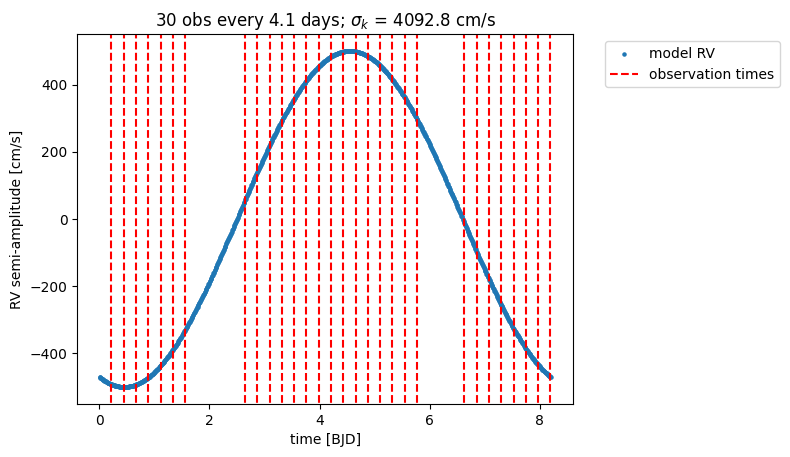

In [216]:
### bad
cadence = cadences[np.argmax(sigma_k_test)] 
print("cadence: ", cadence)
n_obs = 30

"""
sigma_k, sigma_k_stable, sigma_k_solve, fim = strategy(start=2300, n_obs=n_obs, cadence=cadence, theta=test_theta, sigma_val=30)
print("FIM: ", fim)
print("sigma_k using linalg.inv: ", sigma_k)
print("sigma_k using linalg.solve: ", sigma_k_solve)
print("sigma_k using 1/sqrt(FIM_ii): ", sigma_k_stable)
"""
### CALCULATE FIM
end = start + cadence * n_obs
strat = np.linspace(start, end, n_obs, endpoint=False) + np.random.normal(0, 1./24)
test_sigma_correlated = cov_matrix(strat, params)
test_theta = [test_K, test_P, test_T0]

### CALCULATE FIM
#fim = calculate_fim_array(strat, test_sigma_correlated, test_theta)
partial_k = partial_mu(strat, test_theta, 'K')
partial_p = partial_mu(strat, test_theta, 'P')
partial_t = partial_mu(strat, test_theta, 'T0')
print(partial_k[0:10], partial_p[0:10], partial_t[0:10])

"""
### check partials calculated with and without JAX
jac = jax.jacfwd(model_jax, argnums=[1,2,3])
partials = np.array(jac(strat, float(test_K), float(test_P), float(test_T0)))
partial_k = partials[0]
partial_p = partials[1]
partial_t = partials[2]
print(partial_k[0:10], partial_p[0:10], partial_t[0:10])
dfadfasdf
"""

#print(np.dot(np.dot(partial_k, factor2), partial_k))
#print(np.array([np.dot(np.dot(partial_k, factor2), partial_k), np.dot(np.dot(partial_k, factor2), partial_p), np.dot(np.dot(partial_k, factor2), partial_t)]))
factor2 = np.linalg.solve(test_sigma_correlated, np.identity(len(test_sigma_correlated))) # invert to make factor2 for FIM
fim = np.stack([np.array([np.dot(np.dot(partial_k, factor2), partial_k), np.dot(np.dot(partial_k, factor2), partial_p), np.dot(np.dot(partial_k, factor2), partial_t)]),
              np.array([np.dot(np.dot(partial_p, factor2), partial_k), np.dot(np.dot(partial_p, factor2), partial_p), np.dot(np.dot(partial_p, factor2), partial_t)]),
              np.array([np.dot(np.dot(partial_t, factor2), partial_k), np.dot(np.dot(partial_t, factor2), partial_p), np.dot(np.dot(partial_t, factor2), partial_t)])])

inv_fim = inv(fim)
sigma_k = np.sqrt(inv_fim)[0][0]
print("stable sigma K: ", 1/np.sqrt(fim[0][0]))
print("sigma K: ", sigma_k)

### RV model
#start = 2300 # BJD
#end = 2400 # BJD
test_t = np.linspace(2300, 2600, 1000) + np.random.normal(0, 1./24)
test_t_phase_folded = test_t % test_P
#sigma_val = 30+1e-6 # cm/s
#test_sigma = np.ones(len(test_t))*sigma_val
y = model(test_t, test_theta)
y_phase_folded = model(test_t_phase_folded, test_theta)

### plot observations from strategy
end = start + cadence * n_obs
strat = np.linspace(start, end, n_obs) + np.random.normal(0, 1./24)
strat_phase_folded = strat % test_P

plt.scatter(test_t_phase_folded, y_phase_folded, s=5, label='model RV')
plt.axvline(0, 0, 0, linestyle='--', c='r', label='observation times')
for i in strat_phase_folded:
    plt.axvline(i, min(y_phase_folded), max(y_phase_folded), linestyle='--', c='r')
plt.xlabel('time [BJD]')
plt.ylabel('RV semi-amplitude [cm/s]')
plt.title(f'{n_obs} obs every {np.round(cadence, 1)} days; ' + r'${\sigma}_k$' + f' = {np.round(sigma_k, 1)} cm/s')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
#plt.savefig('plots/strategy4.pdf', format='pdf')
plt.show()

cadence:  5.526767676767676
[ 0.00680232  0.88497816 -0.82027753 -0.13097601  0.94067116 -0.73369242
 -0.26625836  0.9784381  -0.63312557 -0.39646672] [-4.14769133e-01 -1.20043467e+02 -2.95151112e+02  7.67581705e+02
 -3.50338469e+02 -8.77004108e+02  1.49300441e+03 -3.73247164e+02
 -1.59869150e+03  2.13316414e+03] [ 383.11219141 -178.3936277  -219.13210616  379.82067368 -130.000468
 -260.32376059  369.29103575  -79.12993126 -296.55450899  351.72393753]
stable sigma K:  54.17715664579941
sigma K:  54.20704745787542


/var/folders/h2/sp_lfvz5515bhg_y92psw7f80000gn/T/ipykernel_47798/1409139590.py:45: RuntimeWarning: invalid value encountered in sqrt
  sigma_k = np.sqrt(inv_fim)[0][0]


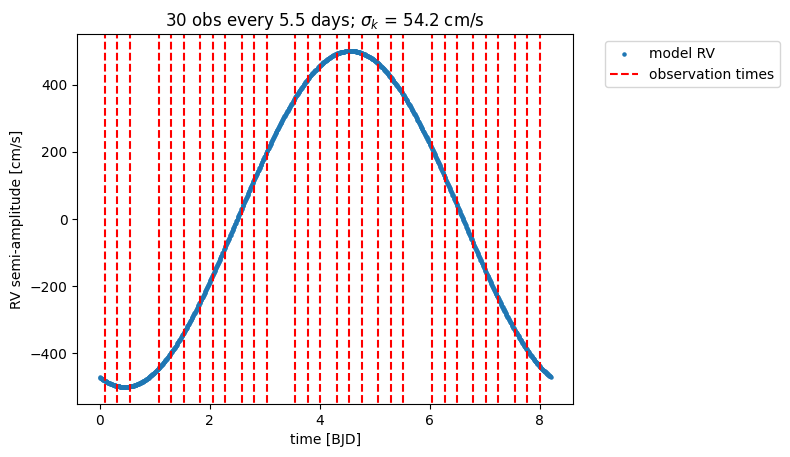

In [211]:
### bad
cadence = cadences[np.argmin(sigma_k_test)] 
print("cadence: ", cadence)
n_obs = 30

"""
sigma_k, sigma_k_stable, sigma_k_solve, fim = strategy(start=2300, n_obs=n_obs, cadence=cadence, theta=test_theta, sigma_val=30)
print("FIM: ", fim)
print("sigma_k using linalg.inv: ", sigma_k)
print("sigma_k using linalg.solve: ", sigma_k_solve)
print("sigma_k using 1/sqrt(FIM_ii): ", sigma_k_stable)
"""
### CALCULATE FIM
end = start + cadence * n_obs
strat = np.linspace(start, end, n_obs, endpoint=False) + np.random.normal(0, 1./24)
test_sigma_correlated = cov_matrix(strat, params)
test_theta = [test_K, test_P, test_T0]

### CALCULATE FIM
#fim = calculate_fim_array(strat, test_sigma_correlated, test_theta)
partial_k = partial_mu(strat, test_theta, 'K')
partial_p = partial_mu(strat, test_theta, 'P')
partial_t = partial_mu(strat, test_theta, 'T0')
print(partial_k[0:10], partial_p[0:10], partial_t[0:10])

"""
### check partials calculated with and without JAX
jac = jax.jacfwd(model_jax, argnums=[1,2,3])
partials = np.array(jac(strat, float(test_K), float(test_P), float(test_T0)))
partial_k = partials[0]
partial_p = partials[1]
partial_t = partials[2]
print(partial_k[0:10], partial_p[0:10], partial_t[0:10])
dfadfasdf
"""

#print(np.dot(np.dot(partial_k, factor2), partial_k))
#print(np.array([np.dot(np.dot(partial_k, factor2), partial_k), np.dot(np.dot(partial_k, factor2), partial_p), np.dot(np.dot(partial_k, factor2), partial_t)]))
factor2 = np.linalg.solve(test_sigma_correlated, np.identity(len(test_sigma_correlated))) # invert to make factor2 for FIM
fim = np.stack([np.array([np.dot(np.dot(partial_k, factor2), partial_k), np.dot(np.dot(partial_k, factor2), partial_p), np.dot(np.dot(partial_k, factor2), partial_t)]),
              np.array([np.dot(np.dot(partial_p, factor2), partial_k), np.dot(np.dot(partial_p, factor2), partial_p), np.dot(np.dot(partial_p, factor2), partial_t)]),
              np.array([np.dot(np.dot(partial_t, factor2), partial_k), np.dot(np.dot(partial_t, factor2), partial_p), np.dot(np.dot(partial_t, factor2), partial_t)])])

inv_fim = inv(fim)
sigma_k = np.sqrt(inv_fim)[0][0]
print("stable sigma K: ", 1/np.sqrt(fim[0][0]))
print("sigma K: ", sigma_k)

### RV model
#start = 2300 # BJD
#end = 2400 # BJD
test_t = np.linspace(2300, 2600, 1000) + np.random.normal(0, 1./24)
test_t_phase_folded = test_t % test_P
sigma_val = 30+1e-6 # cm/s
test_sigma = np.ones(len(test_t))*sigma_val
y = model(test_t, test_theta)
y_phase_folded = model(test_t_phase_folded, test_theta)

### plot observations from strategy
end = start + cadence * n_obs
strat = np.linspace(start, end, n_obs) + np.random.normal(0, 1./24)
strat_phase_folded = strat % test_P

plt.scatter(test_t_phase_folded, y_phase_folded, s=5, label='model RV')
plt.axvline(0, 0, 0, linestyle='--', c='r', label='observation times')
for i in strat_phase_folded:
    plt.axvline(i, min(y_phase_folded), max(y_phase_folded), linestyle='--', c='r')
plt.xlabel('time [BJD]')
plt.ylabel('RV semi-amplitude [cm/s]')
plt.title(f'{n_obs} obs every {np.round(cadence, 1)} days; ' + r'${\sigma}_k$' + f' = {np.round(sigma_k, 1)} cm/s')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
#plt.savefig('plots/strategy4.pdf', format='pdf')
plt.show()

cadence:  6
[ 0.04853078  0.98666588 -0.27483922 -0.92362687  0.48668861  0.81199664
 -0.67293372 -0.65764795  0.82377636  0.46870096] [   -2.95686828   -45.1447725   -536.22750917   321.21361827
   976.98027777  -816.36938921 -1241.98651088  1476.0409519
  1269.71902364 -2226.08761598] [ 382.66961905  -62.35634892 -368.36713967  146.84755968  334.68517736
 -223.61324482 -283.3957116   288.61482672  217.1970377  -338.43262726]
stable sigma K:  55.88066403542165
sigma K:  55.92345591046313


/var/folders/h2/sp_lfvz5515bhg_y92psw7f80000gn/T/ipykernel_47798/3659617890.py:45: RuntimeWarning: invalid value encountered in sqrt
  sigma_k = np.sqrt(inv_fim)[0][0]


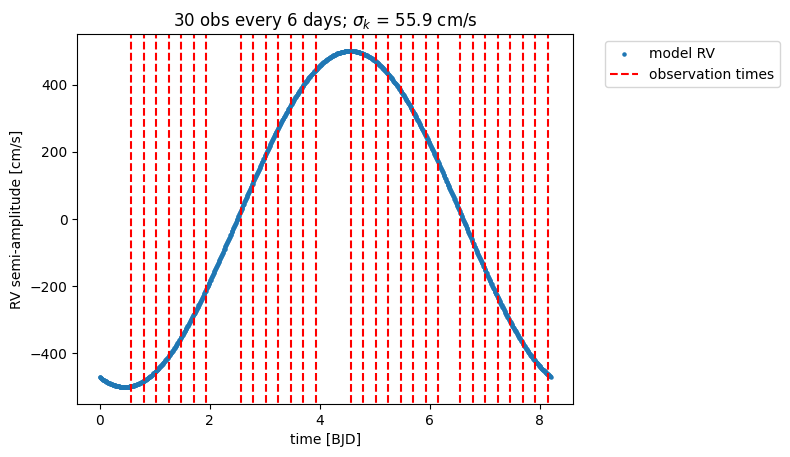

In [217]:
### bad
cadence = 6
print("cadence: ", cadence)
n_obs = 30

"""
sigma_k, sigma_k_stable, sigma_k_solve, fim = strategy(start=2300, n_obs=n_obs, cadence=cadence, theta=test_theta, sigma_val=30)
print("FIM: ", fim)
print("sigma_k using linalg.inv: ", sigma_k)
print("sigma_k using linalg.solve: ", sigma_k_solve)
print("sigma_k using 1/sqrt(FIM_ii): ", sigma_k_stable)
"""
### CALCULATE FIM
end = start + cadence * n_obs
strat = np.linspace(start, end, n_obs, endpoint=False) + np.random.normal(0, 1./24)
test_sigma_correlated = cov_matrix(strat, params)
test_theta = [test_K, test_P, test_T0]

### CALCULATE FIM
#fim = calculate_fim_array(strat, test_sigma_correlated, test_theta)
partial_k = partial_mu(strat, test_theta, 'K')
partial_p = partial_mu(strat, test_theta, 'P')
partial_t = partial_mu(strat, test_theta, 'T0')
print(partial_k[0:10], partial_p[0:10], partial_t[0:10])

"""
### check partials calculated with and without JAX
jac = jax.jacfwd(model_jax, argnums=[1,2,3])
partials = np.array(jac(strat, float(test_K), float(test_P), float(test_T0)))
partial_k = partials[0]
partial_p = partials[1]
partial_t = partials[2]
print(partial_k[0:10], partial_p[0:10], partial_t[0:10])
dfadfasdf
"""

#print(np.dot(np.dot(partial_k, factor2), partial_k))
#print(np.array([np.dot(np.dot(partial_k, factor2), partial_k), np.dot(np.dot(partial_k, factor2), partial_p), np.dot(np.dot(partial_k, factor2), partial_t)]))
factor2 = np.linalg.solve(test_sigma_correlated, np.identity(len(test_sigma_correlated))) # invert to make factor2 for FIM
fim = np.stack([np.array([np.dot(np.dot(partial_k, factor2), partial_k), np.dot(np.dot(partial_k, factor2), partial_p), np.dot(np.dot(partial_k, factor2), partial_t)]),
              np.array([np.dot(np.dot(partial_p, factor2), partial_k), np.dot(np.dot(partial_p, factor2), partial_p), np.dot(np.dot(partial_p, factor2), partial_t)]),
              np.array([np.dot(np.dot(partial_t, factor2), partial_k), np.dot(np.dot(partial_t, factor2), partial_p), np.dot(np.dot(partial_t, factor2), partial_t)])])

inv_fim = inv(fim)
sigma_k = np.sqrt(inv_fim)[0][0]
print("stable sigma K: ", 1/np.sqrt(fim[0][0]))
print("sigma K: ", sigma_k)

### RV model
#start = 2300 # BJD
#end = 2400 # BJD
test_t = np.linspace(2300, 2600, 1000) + np.random.normal(0, 1./24)
test_t_phase_folded = test_t % test_P
#sigma_val = 30+1e-6 # cm/s
#test_sigma = np.ones(len(test_t))*sigma_val
y = model(test_t, test_theta)
y_phase_folded = model(test_t_phase_folded, test_theta)

### plot observations from strategy
end = start + cadence * n_obs
strat = np.linspace(start, end, n_obs) + np.random.normal(0, 1./24)
strat_phase_folded = strat % test_P

plt.scatter(test_t_phase_folded, y_phase_folded, s=5, label='model RV')
plt.axvline(0, 0, 0, linestyle='--', c='r', label='observation times')
for i in strat_phase_folded:
    plt.axvline(i, min(y_phase_folded), max(y_phase_folded), linestyle='--', c='r')
plt.xlabel('time [BJD]')
plt.ylabel('RV semi-amplitude [cm/s]')
plt.title(f'{n_obs} obs every {np.round(cadence, 1)} days; ' + r'${\sigma}_k$' + f' = {np.round(sigma_k, 1)} cm/s')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
#plt.savefig('plots/strategy4.pdf', format='pdf')
plt.show()

In [73]:
np.array(sigma_k_test)[np.round(np.array(cadences), 2) == 3.01][0]

57.12883465725731

In [70]:
cadences

array([0.3       , 0.36616162, 0.43232323, 0.49848485, 0.56464646,
       0.63080808, 0.6969697 , 0.76313131, 0.82929293, 0.89545455,
       0.96161616, 1.02777778, 1.09393939, 1.16010101, 1.22626263,
       1.29242424, 1.35858586, 1.42474747, 1.49090909, 1.55707071,
       1.62323232, 1.68939394, 1.75555556, 1.82171717, 1.88787879,
       1.9540404 , 2.02020202, 2.08636364, 2.15252525, 2.21868687,
       2.28484848, 2.3510101 , 2.41717172, 2.48333333, 2.54949495,
       2.61565657, 2.68181818, 2.7479798 , 2.81414141, 2.88030303,
       2.94646465, 3.01262626, 3.07878788, 3.14494949, 3.21111111,
       3.27727273, 3.34343434, 3.40959596, 3.47575758, 3.54191919,
       3.60808081, 3.67424242, 3.74040404, 3.80656566, 3.87272727,
       3.93888889, 4.00505051, 4.07121212, 4.13737374, 4.20353535,
       4.26969697, 4.33585859, 4.4020202 , 4.46818182, 4.53434343,
       4.60050505, 4.66666667, 4.73282828, 4.7989899 , 4.86515152,
       4.93131313, 4.99747475, 5.06363636, 5.12979798, 5.19595